In [1]:
import duckdb
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.scale import LogScale
from matplotlib.ticker import FuncFormatter
import matplotlib.patheffects as PathEffects
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import copy

import seaborn as sns
import seaborn.objects as so
from seaborn import axes_style
from seaborn import plotting_context

In [2]:
deep = sns.color_palette('deep')
deep

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [3]:
for c in deep[3]:
    print(255*c)

196.0
78.0
82.0


In [4]:
palette = [deep[1], deep[2]]

In [5]:
con = duckdb.connect()

con.execute("""
CREATE MACRO pretty_system(s) AS
CASE s
WHEN 'duckdb' THEN 'DuckDB'
WHEN 'hyper' THEN 'HyPer'
WHEN 'postgresql' THEN 'PostgreSQL'
WHEN 'umbra' THEN 'Umbra'
ELSE s END
""")

systems = ["duckdb", "hyper"]

for system in sorted(systems):
    con.execute(f"""ATTACH IF NOT EXISTS '../results/{system}.duckdb' AS {system} (READ_ONLY TRUE);""")
con.execute(f"""CREATE VIEW IF NOT EXISTS all_results AS ({' UNION ALL '.join([f"SELECT '{system}' AS system, * FROM {system}.main.results" for system in systems])})""")
results_int_df = con.execute("""
SELECT * REPLACE (median(t) AS t)
FROM all_results
GROUP BY ALL
ORDER BY ALL""").fetchdf()
results_df = con.execute("""SELECT * REPLACE(sf::VARCHAR as sf) FROM results_int_df""").fetchdf()
results_df.head()

,system,sf,q,t
0,duckdb,1000,1,37.904115
1,duckdb,1000,2,5.813019
2,duckdb,1000,3,63.435100
3,duckdb,1000,4,44.960592
4,duckdb,1000,5,60.513304


In [6]:
my_style = {
    'figure.facecolor': 'white',
    'axes.labelcolor': '.15',
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.color': '.15',
    'ytick.color': '.15',
    'axes.axisbelow': True,
    'grid.linestyle': '-',
    'text.color': '.0',
    'font.family': ['sans-serif'],
    'font.sans-serif': [
        'Arial',
        'DejaVu Sans',
        'Liberation Sans',
        'Bitstream Vera Sans',
        'sans-serif'
    ],
    'lines.solid_capstyle': 'round',
    'patch.edgecolor': 'w',
    'patch.force_edgecolor': True,
    'image.cmap': 'rocket',
    'xtick.top': False,
    'ytick.right': False,
    'axes.grid': True,
    'axes.facecolor': 'white',
    'axes.edgecolor': '.0',
    'grid.color': '.75',
    'axes.spines.left': True,
    'axes.spines.bottom': False,
    'axes.spines.right': True,
    'axes.spines.top': True,
    'xtick.bottom': False,
    'ytick.left': False
}

In [7]:
@FuncFormatter
def my_formatter(x, pos):
    if x >= 1:
        # print("{:.0f}".format(x))
        return "{:.0f}".format(x)
    # print("{:.1g}".format(x))
    return "{:.1g}".format(x)

/var/folders/xb/2cf2mnw979g7ts_gvf4nry7h0000gn/T/ipykernel_80464/1548282036.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_bot.set_xticklabels(xticklabels , fontsize=tickfontsize)
/var/folders/xb/2cf2mnw979g7ts_gvf4nry7h0000gn/T/ipykernel_80464/1548282036.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


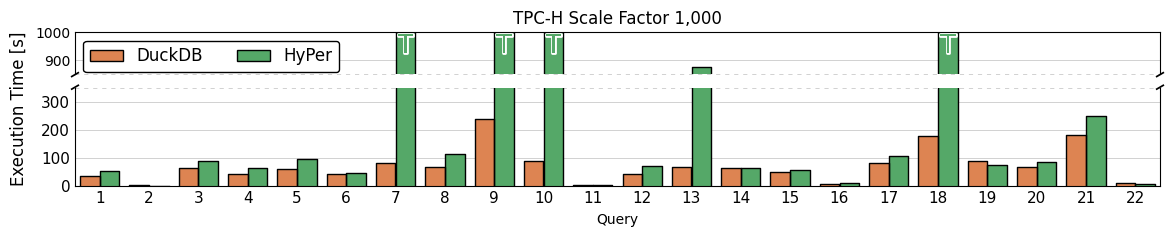

In [8]:
f, (ax_top, ax_bot) = plt.subplots(2, 1, sharex=True, figsize=(14, 2.0), dpi=100,
                                   gridspec_kw={'height_ratios': [150, 350], 'wspace': -50})

fontsize = 12
tickfontsize = 11

modified_style = copy.copy(my_style)
modified_style['axes.labelsize'] = fontsize
modified_style['ytick.labelsize'] = tickfontsize
modified_style['grid.linewidth'] = 0.5
modified_style['xtick.major.bottom'] = False

for i, ax in enumerate([ax_top, ax_bot]):
    p = (
        so.Plot(
            con.execute(f"""
                SELECT pretty_system(system) as "System", q::VARCHAR as "Query",
                       CASE t WHEN -1 THEN 1000 ELSE t END AS "Execution Time [s]", 
                FROM results_df
            """).fetchdf(),
            x='Query', y='Execution Time [s]', color='System'
        )
        .scale(color=palette)
        .add(so.Bar(alpha=1), so.Dodge(gap=0.01))
        .theme(modified_style)
        .on(ax)
        .plot()
    )
    legend = f.legends.pop(0)

ax_top.set_title('TPC-H Scale Factor 1,000', fontsize=fontsize)

timeouts = [7, 9, 10, 18]
ax_bot.tick_params(axis='x', which='major')
xticklabels = ax_bot.get_xticklabels()
ax_bot.set_xticklabels(xticklabels , fontsize=tickfontsize)
ax_bot.xaxis.labelpad = 5
xmin, xmax = ax_bot.get_xlim()
ax_bot.set_xlim(xmin, xmax)
ax_top.set_xlabel('')
ax_top.tick_params(axis='both', which='both', length=0, labelbottom=False)
ax_bot.tick_params(axis='both', which='both', length=0, labelbottom=True)

ax_top.yaxis.labelpad = 0
ax_bot.yaxis.labelpad = 0

ax_top.set_ylabel('')
ax_bot.set_ylabel('')

ax_bot.set_ylim(0, 350)
yticklabels = [i * 100 for i in range(4)]
ax_bot.set_yticks(yticklabels)
ax_bot.set_yticklabels(yticklabels , fontsize=tickfontsize)

ax_top.set_ylim(850, 1000)

# ax_top.spines['bottom'].set_visible(False)
# ax_bot.spines['top'].set_visible(False)
ax_top.spines['bottom'].set_linestyle((0, (5, 8)))
ax_bot.spines['top'].set_linestyle((0, (5, 8)))
ax_top.spines['bottom'].set_lw(0.5)
ax_bot.spines['top'].set_lw(0.5)
ax_top.spines['bottom'].set_color('0.75')
ax_bot.spines['top'].set_color('0.75')
ax_top.spines['bottom'].set_zorder(0)
ax_bot.spines['top'].set_zorder(0)

for ax in [ax_top, ax_bot]:
    ax.set_axisbelow(True)
    ax.grid(True, alpha=1.0, color='0.75', axis='y', lw=0.5)

for ax_idx, ax in enumerate([ax_top, ax_bot]):
    # Iterate over the bars and manually add the top and side edges
    
    for i, bar in enumerate(ax.patches):
        x, y, width, height = bar.get_x(), bar.get_y(), bar.get_width(), bar.get_height()

        if ax_idx == 0:
            timed_out = i - 21 in timeouts
            if timed_out:
                txt = ax.text(x + width / 2, height - 5, 'T', horizontalalignment='center', verticalalignment='top', color=palette[1], fontsize=18)
                txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
        
        # Manually draw the edges
        ax.plot([x, x, x + width, x + width], [y, y + height, y + height, y], color='black', lw=1)

f.text(0.085, 0.5, 'Execution Time [s]', rotation=90, horizontalalignment='center', verticalalignment='center', fontsize=fontsize)

for handle in legend.legend_handles:
    handle.set_edgecolor('black')
    handle.set_lw(1)
ax_top.legend(legend.legend_handles, [t.get_text() for t in legend.texts], loc='upper left', framealpha=1, fontsize=fontsize, ncol=2, edgecolor='black')

# Add diagonal lines to indicate a break in the y-axis
d = 0.003  # Size of the diagonal line break
top_mult = 15
bottom_mult = top_mult * 150/350
offset = 0.01
kwargs = dict(transform=ax_top.transAxes, color='k', clip_on=False, linewidth=1.25)
ax_top.plot((-d, +d), (-d*top_mult - offset, +d*top_mult - offset), **kwargs)  # Top-left diagonal
ax_top.plot((1 - d, 1 + d), (-d*top_mult - offset, +d*top_mult - offset), **kwargs)  # Top-right diagonal

kwargs.update(transform=ax_bot.transAxes)  # Switch to the bottom axes for the second diagonal
ax_bot.plot((-d, +d), (1 - d*bottom_mult + offset, 1 + d*bottom_mult + offset), **kwargs)  # Bottom-left diagonal
ax_bot.plot((1 - d, 1 + d), (1 - d*bottom_mult + offset, 1 + d*bottom_mult + offset), **kwargs)  # Bottom-right diagonal

f.tight_layout()
f.savefig(f"../figures/bar.eps", bbox_inches='tight')
f.savefig(f"../figures/bar.pdf", bbox_inches='tight')
f.savefig(f"../figures/bar.png", bbox_inches='tight')